In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
dataset = pd.read_csv('./household_power_consumption.csv', header=0, infer_datetime_format=True,
                     parse_dates=['datetime'], index_col=['datetime'])

In [4]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


## Exploratory Data Analysis

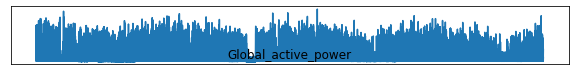

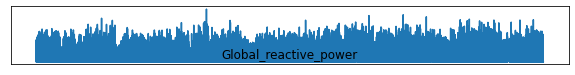

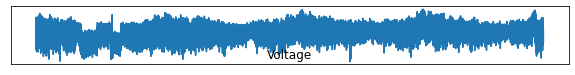

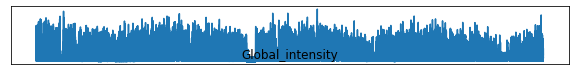

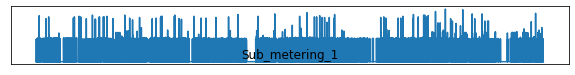

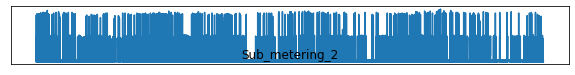

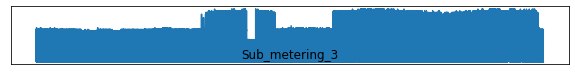

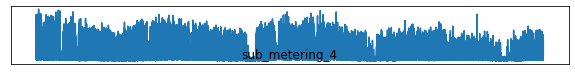

In [5]:
for i in range(len(dataset.columns)):
    pyplot.figure(figsize=(10,10))
    # create subplot
    pyplot.subplot(len(dataset.columns), 1, i+1)
    # get variable name
    name = dataset.columns[i]
    # plot data
    pyplot.plot(dataset[name])
    # set title
    pyplot.title(name, y=0)
    # turn off ticks to remove clutter
    pyplot.yticks([])
    pyplot.xticks([])
    pyplot.show()

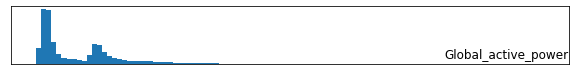

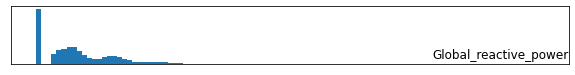

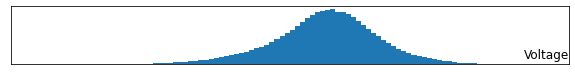

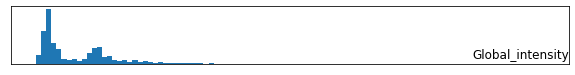

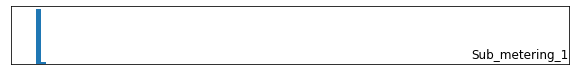

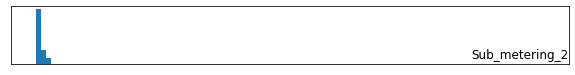

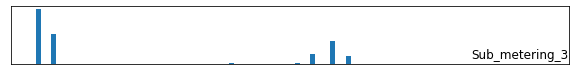

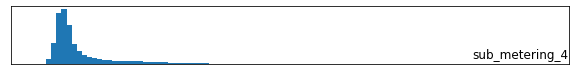

In [6]:
for i in range(len(dataset.columns)):
    pyplot.figure(figsize=(10,10))
    # create subplot
    pyplot.subplot(len(dataset.columns), 1, i+1)
    # get variable name
    name = dataset.columns[i]
    # create histogram
    dataset[name].hist(bins=100)
    # set title
    pyplot.title(name, y=0, loc='right')
    # turn off ticks to remove clutter
    pyplot.yticks([])
    pyplot.xticks([])
    pyplot.show()

## Data preprocessing for modelling

In [11]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
                
# fill missing
fill_missing(dataset.values)

In [14]:
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
daily_data.to_csv('household_power_consumption_days.csv')
daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14680.933594
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,36946.667969
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0,19028.433594
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0,13131.900391
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0,20384.800781


## Evaluation Metric

A forecast will be comprised of seven values, one for each day of the week ahead. It is common
with multi-step forecasting problems to evaluate each forecasted time step separately. This is
helpful for a few reasons:

- To comment on the skill at a specific lead time (e.g. +1 day vs +3 days).
- To contrast models based on their skills at different lead times (e.g. models good at +1
day vs models good at days +5).

In [20]:
# evaluate one or more weekly forecasts against expected values

# The error measure that will be used is rsme

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

## Train and Test Sets

We will use the first three years of data for training predictive models and the final year for
evaluating models.


In [45]:
# split the power usage dataset into standard weeks

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

In [46]:

# load the new file
dataset = pd.read_csv('household_power_consumption_days.csv', header=0,
                    infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# make dataset numeric
dataset = dataset.astype('float32')

#split dataset
train, test = split_dataset(dataset.values)

# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.268
(46, 7, 8)
2083.454 2197.006


## Walk-Forward Validation

Models will be evaluated using a scheme called walk-forward validation. This is where a model
is required to make a one week prediction, then the actual data for that week is made available
to the model so that it can be used as the basis for making a prediction on the subsequent week.

In [51]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    
    # walk-forward validation over each week
    predictions = []
    for i in range(len(test)):
        
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    
    #evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [48]:
# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    value = last_week[-1, 0]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

# weekly persistence model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]

# week one year ago persistence model
def week_one_year_ago_persistence(history):
    # get the data for the prior week
    last_week = history[-52]
    return last_week[:, 0]

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1


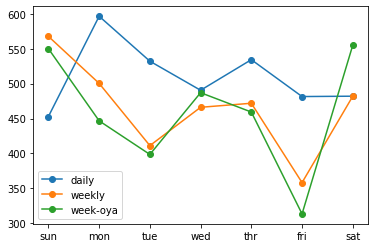

In [55]:
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence

# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
    
# show plot
pyplot.legend()
pyplot.show()